In [100]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().resolve().parent.parent))

In [ ]:
# running experiments
from experiments.run_experiment import (
    TrainingConfig,
    EvaluateConfig,
)
from experiments.run_sweep import run_sweep, plot_sweep_training, plot_sweep_evaluation
from experiments.sweep_utils import asymmetric_alphas

# environments
from environments.fronzenlake import FrozenLakeConfig, get_frozenlake_env

# SARSA positivty bias agent
from agents.sarsa_td0_positivity_bias import (
    SarsaTD0PositivityBiasConfig,
    SarsaTD0PositivityBiasAgent,
)

# SARSA confirmation bias agent
from agents.sarsa_td0_confirmation_bias import (
    SarsaTD0ConfirmationBiasConfig,
    SarsaTD0ConfirmationBiasAgent,
)

# metrics for training
from src.metrics.reward_mertrics import total_reward_per_episode, episode_won_frozenlake
from metrics.frustration_metrics import (
    total_td_error_per_episode,
    mean_negative_td_error_per_episode,
    negative_td_error_sum_per_episode,
    frustration_rate_per_episode,
    tail_frustration_per_episode,
    cvar_tail_frustration_per_episode,
)

# external libraries
import numpy as np

## Environments

In [104]:
# env_config = FrozenLakeConfig(map_name="4x4", is_slippery=False)
env_config = FrozenLakeConfig(
    map_name="4x4",
    is_slippery=False,
    reward_schedule=(1, -1, -0.1),
)

## Agents

In [ ]:
## Agents
# sarsa_td0 confirmation bias agent
agent_factory = SarsaTD0ConfirmationBiasAgent

sarsa_td0_config = SarsaTD0ConfirmationBiasConfig(
    alpha_conf=0.2,
    alpha_disconf=0.2,
    gamma=0.99,
    epsilon=0.1,
    reward_metrics={
        "total_reward_per_episode": total_reward_per_episode,
        "episode_won": episode_won_frozenlake,
    },
    td_error_metrics={
        "total_td_error_per_episode": total_td_error_per_episode,
        "mean_negative_td_error_per_episode": mean_negative_td_error_per_episode,
        "negative_td_error_sum_per_episode": negative_td_error_sum_per_episode,
        "frustration_rate_per_episode": frustration_rate_per_episode,
        "tail_frustration_per_episode": lambda td: tail_frustration_per_episode(
            td, percentile=0.90
        ),
        "cvar_tail_frustration_per_episode": lambda td: cvar_tail_frustration_per_episode(
            td, percentile=0.90
        ),
    },
)

## Sweep configuration

In [149]:
base_train = TrainingConfig(
    name="FrozenLake_sarsa_td0",
    num_train_episodes=1000,
    env_kwargs={"config": env_config},
    agent_kwargs={"config": sarsa_td0_config},
)

base_eval = EvaluateConfig(
    name="FrozenLake_sarsa_td0",
    num_eval_episodes=100,
    env_kwargs={"config": env_config},
)

In [150]:
# different q_tables
env = get_frozenlake_env(env_config)
num_states = env.observation_space.n
num_actions = env.action_space.n
# q0 = np.ones((num_states, num_actions), dtype=np.float64) * -1
q0 = np.zeros((num_states, num_actions), dtype=np.float64)

## Confirmation bias results

In [158]:
# average (alpha_conf + alpha_disconf) / 2 = 0.10
confirmatory_pairs = [
    #   (0.15, 0.05),
    (0.125, 0.075)
]

balanced_pairs = [
    (0.10, 0.10),
]

disconfirmatory_pairs = [
    (0.075, 0.125),
    #  (0.05, 0.15),
]

alpha_pairs = confirmatory_pairs + balanced_pairs + disconfirmatory_pairs
seeds = list(range(100))  # 20 different seeds

sweep = {
    "agent_kwargs": [
        {
            "alpha_conf": a_conf,
            "alpha_disconf": a_disconf,
            "seed": seed,
            "initial_q_table": q0,
            "initial_q_table_label": "zeros",
        }
        for (a_conf, a_disconf) in alpha_pairs
        for seed in seeds
    ],
}

In [152]:
seeds = list(range(100))  # 20 different seeds

sweep = {
    "agent_kwargs": [
        {
            "seed": seed,
        }
        for seed in seeds
    ],
}

In [159]:
results = run_sweep(
    base_training=base_train,
    base_evaluation=base_eval,
    sweep=sweep,
    env_factory=get_frozenlake_env,
    agent_factory=agent_factory,
)


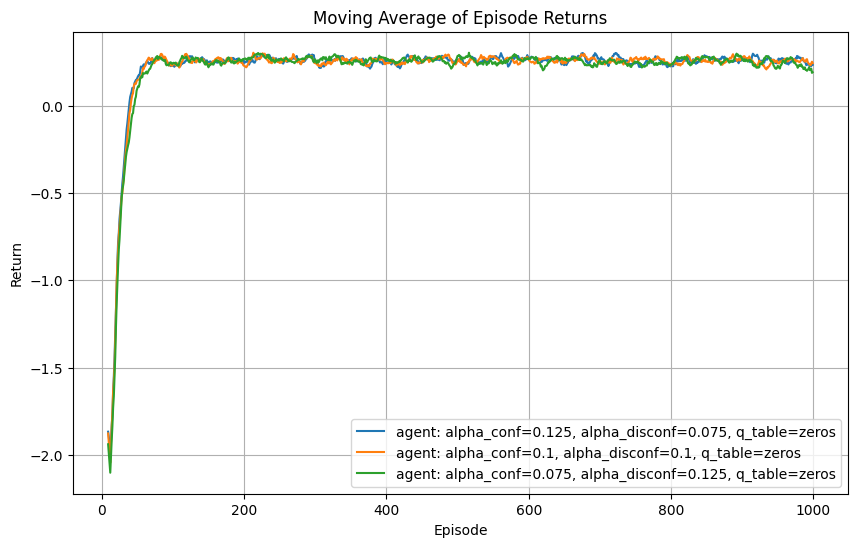

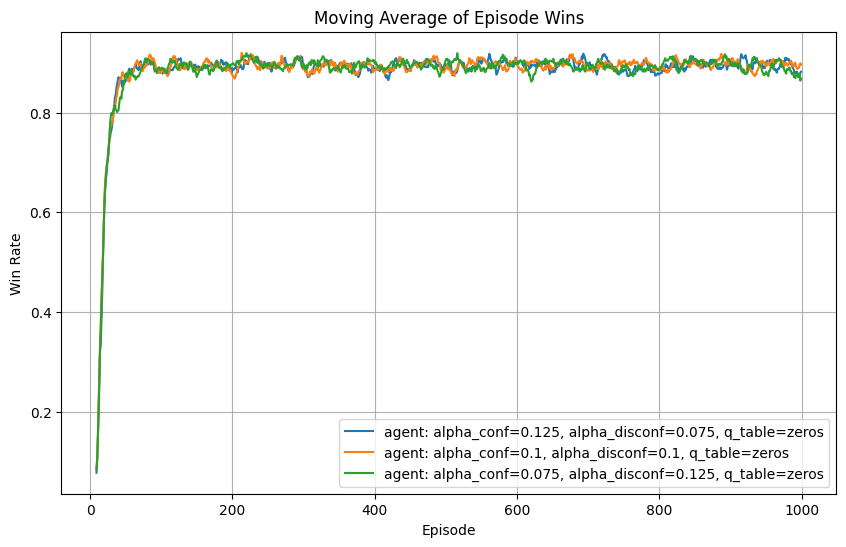

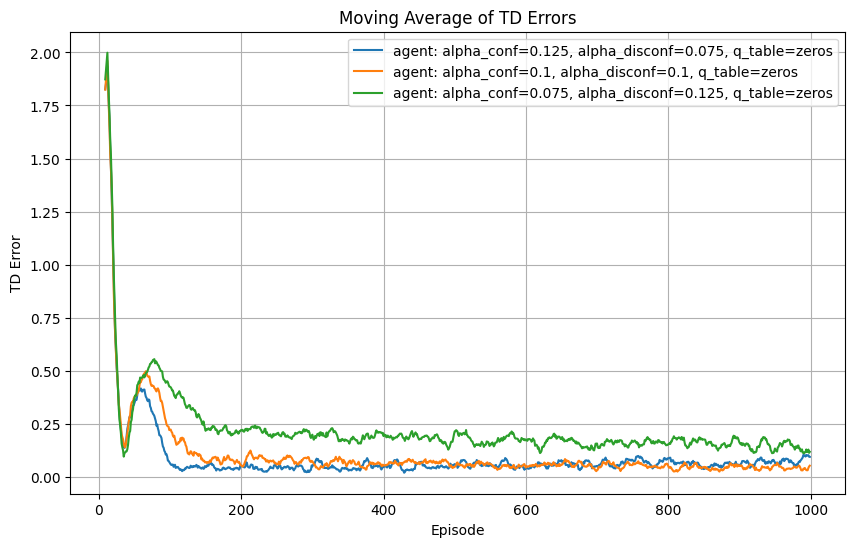

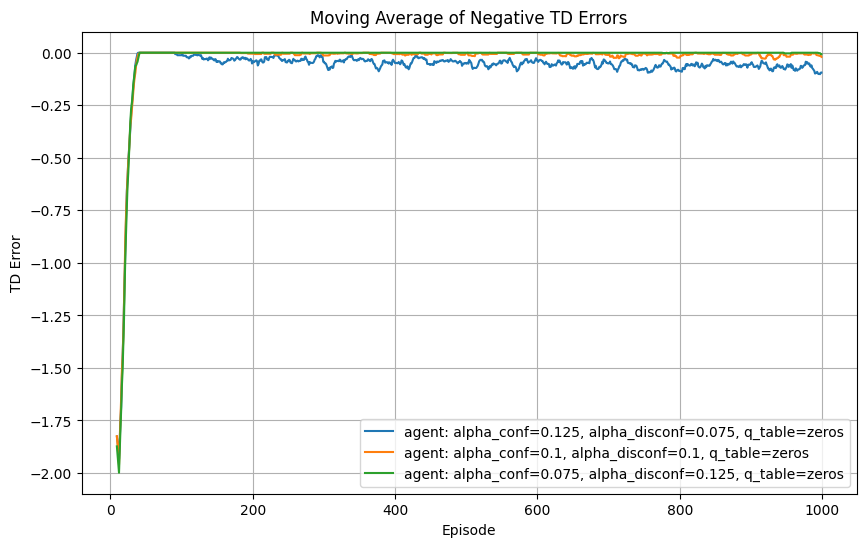

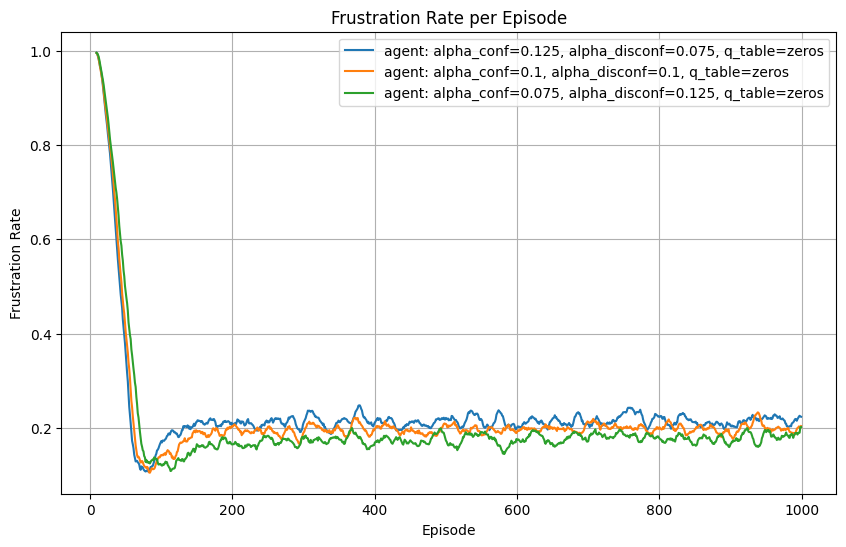

In [160]:
plot_sweep_training(results, window_size=10)

In [58]:
# compare td_error vs td_error_v moving averages for one run
from plots.td_error_plots import (
    plot_moving_average_td_errors_multi,
    plot_moving_average_td_errors_neg_multi,
)

run_index = 0
td_error_metrics = results[run_index]["training"]["td_error"]
td_errors = td_error_metrics.get("total_td_error_per_episode")
td_errors_v = td_error_metrics.get("total_td_error_per_episode_v")
if td_errors is None or td_errors_v is None:
    raise ValueError("Missing td_error series; check metrics keys.")

plot_moving_average_td_errors_multi(
    {"td_error": td_errors, "td_error_v": td_errors_v}, window=100
)
plot_moving_average_td_errors_neg_multi(
    {"td_error": td_errors, "td_error_v": td_errors_v}, window=100
)


ValueError: Missing td_error series; check metrics keys.

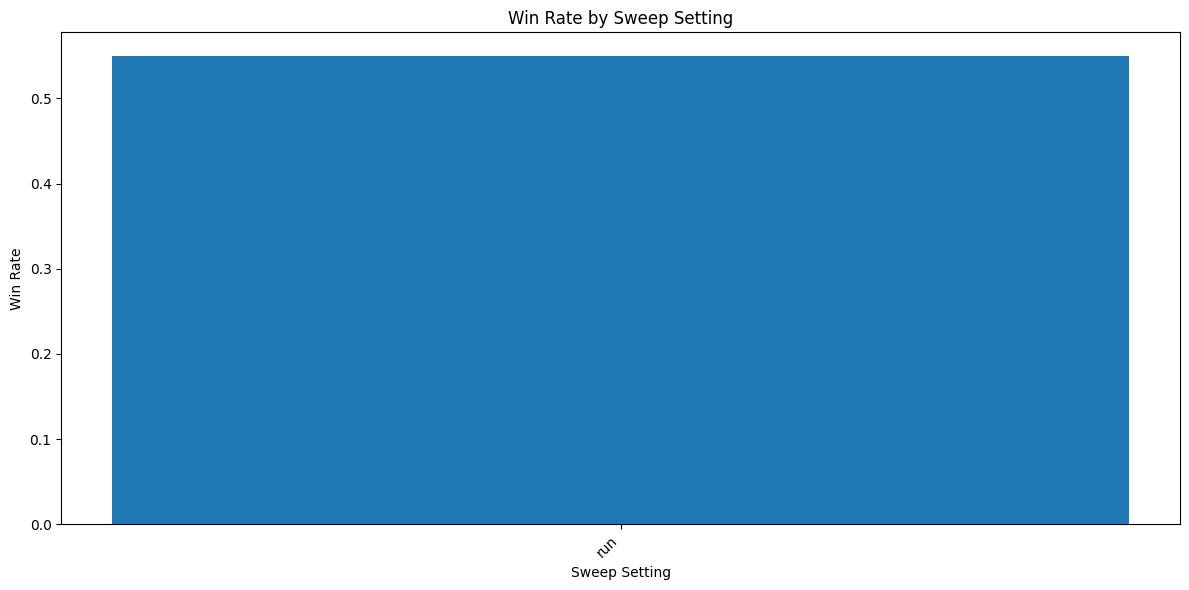

In [73]:
plot_sweep_evaluation(results)

## Positivity bias results

In [161]:
## Agents
# sarsa_td0 agent
agent_factory = SarsaTD0PositivityBiasAgent

sarsa_td0_config = SarsaTD0PositivityBiasConfig(
    alpha_positive=0.1,
    alpha_negative=0.1,
    gamma=0.99,
    epsilon=0.1,
    reward_metrics={
        "total_reward_per_episode": total_reward_per_episode,
        "episode_won": episode_won_frozenlake,
    },
    td_error_metrics={
        "total_td_error_per_episode": total_td_error_per_episode,
        "frustration_rate_per_episode": frustration_rate_per_episode,
        "tail_frustration_per_episode": lambda td: tail_frustration_per_episode(
            td, percentile=0.90
        ),
        "cvar_tail_frustration_per_episode": lambda td: cvar_tail_frustration_per_episode(
            td, percentile=0.90
        ),
    },
)

In [167]:
base_train = TrainingConfig(
    name="TaxiV3_sarsa_td0",
    num_train_episodes=1000,
    env_kwargs={"config": env_config},
    agent_kwargs={"config": sarsa_td0_config},
)

base_eval = EvaluateConfig(
    name="TaxiV3_sarsa_td0",
    num_eval_episodes=1000,
    env_kwargs={"config": env_config},
)

In [168]:
# different q_tables
env = get_frozenlake_env(env_config)
num_states = env.observation_space.n
num_actions = env.action_space.n
q0 = np.zeros((num_states, num_actions), dtype=np.float64)

In [169]:
# mean alpha_0 = 0.2
a_0 = 0.1
ratios = [0.5, 0.75, 1.0, 1.25, 1.5]

seeds = list(range(50))
sweep = {
    "agent_kwargs": [
        {
            **asymmetric_alphas(a_0, r),  # gives alpha_positive / alpha_negative
            "seed": seed,
            "initial_q_table": q0,
            "initial_q_table_label": "zeros",
        }
        for r in ratios
        for seed in seeds
    ],
}

In [170]:
results = run_sweep(
    base_training=base_train,
    base_evaluation=base_eval,
    sweep=sweep,
    env_factory=get_frozenlake_env,
    agent_factory=agent_factory,
)

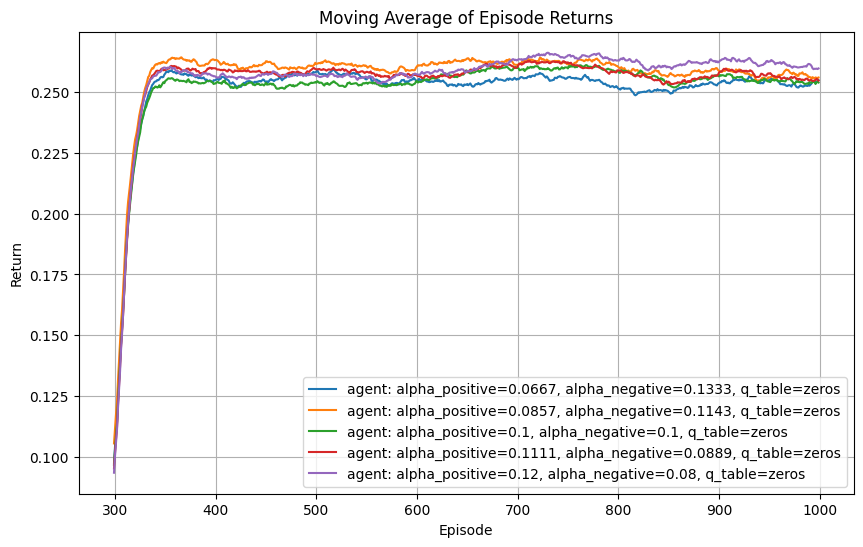

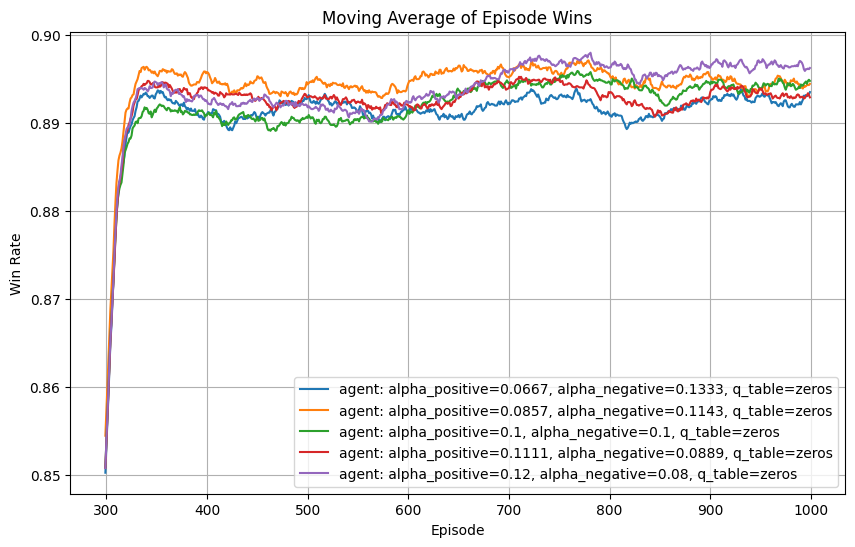

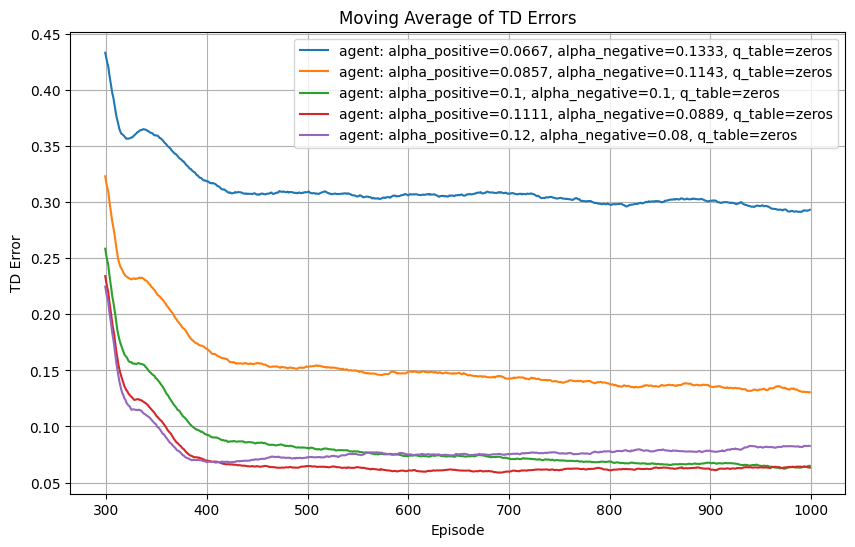

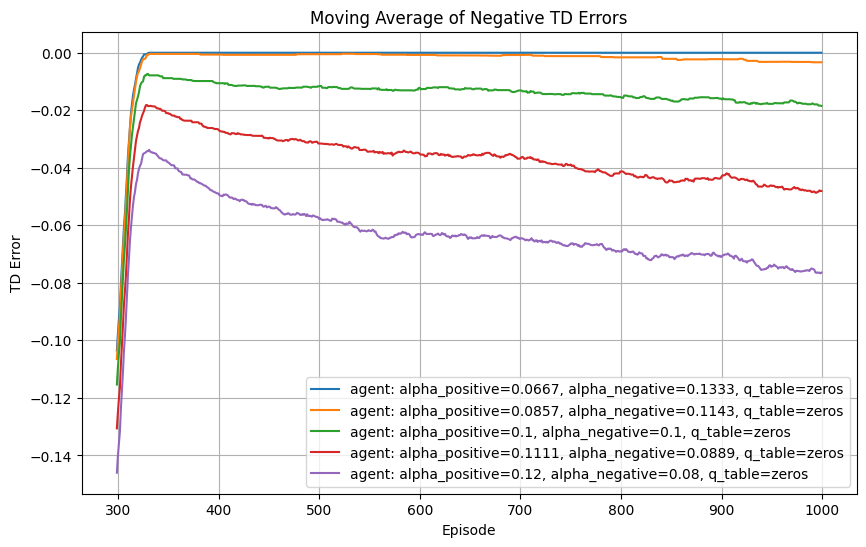

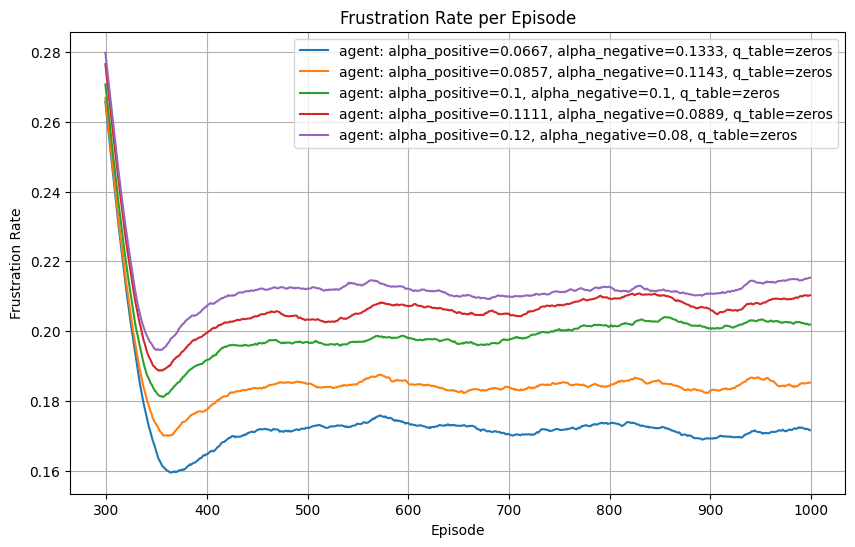

In [171]:
plot_sweep_training(results, window_size=300)

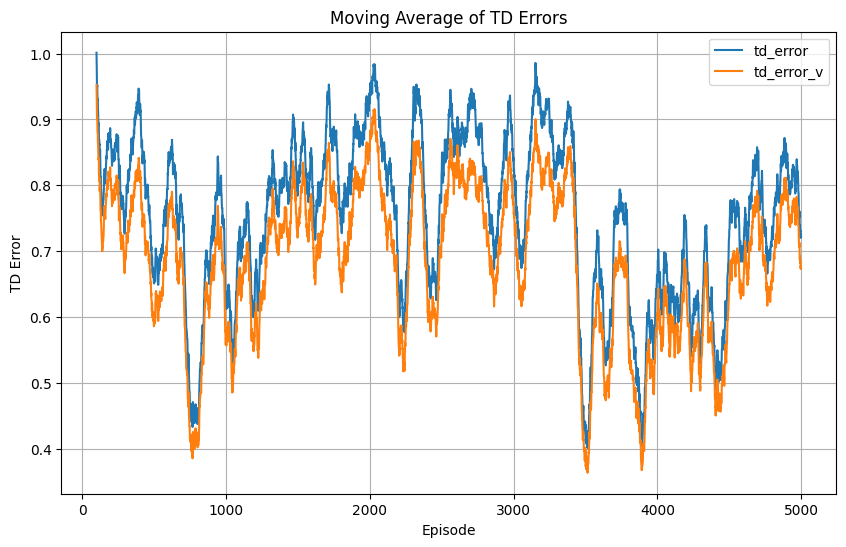

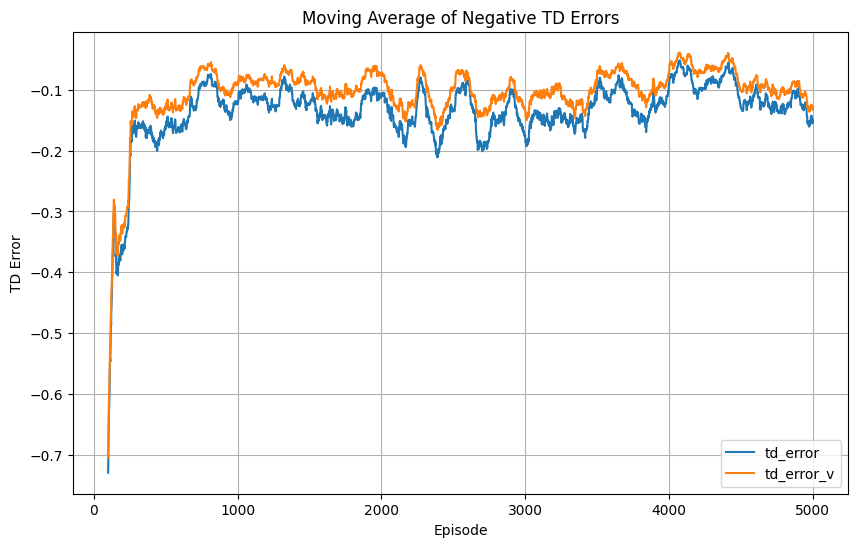

In [38]:
# compare td_error vs td_error_v moving averages for one run
from plots.td_error_plots import (
    plot_moving_average_td_errors_multi,
    plot_moving_average_td_errors_neg_multi,
)

run_index = 0
td_error_metrics = results[run_index]["training"]["td_error"]
td_errors = td_error_metrics.get("total_td_error_per_episode")
td_errors_v = td_error_metrics.get("total_td_error_per_episode_v")
if td_errors is None or td_errors_v is None:
    raise ValueError("Missing td_error series; check metrics keys.")

plot_moving_average_td_errors_multi(
    {"td_error": td_errors, "td_error_v": td_errors_v}, window=100
)
plot_moving_average_td_errors_neg_multi(
    {"td_error": td_errors, "td_error_v": td_errors_v}, window=100
)

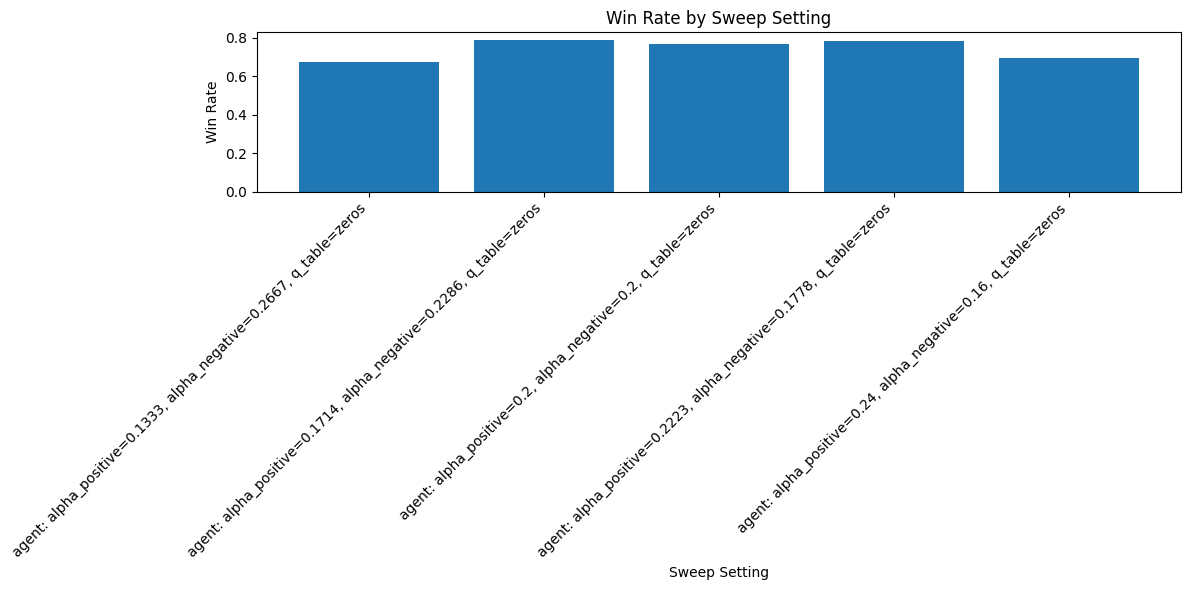

In [39]:
plot_sweep_evaluation(results)